In [1]:
# This notebook checks is trying different pipeline approaches

# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
import pyprep as pp


In [2]:

#from Functions.main_meg_qc import initial_stuff
from Functions. data_load_and_folders import load_meg_data
duration=5 #in minutes
#n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads, mags, grads, filtered_d, filtered_d_resamp, raw_cropped, raw=initial_stuff(duration)

raw_file = './data/sub_HT05ND16/210811/mikado-1.fif/'
raw, mags, grads = load_meg_data(raw_file)

#crop the data to calculate faster
raw_cropped = raw.copy()
raw_cropped.crop(0, duration*60) 



Opening raw data file ./data/sub_HT05ND16/210811/mikado-1.fif/...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 3

/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:8: RuntimeWarning: This filename (./data/sub_HT05ND16/210811/mikado-1.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file)


        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 3376000 ... 4942999 =   3376.000 ...  4942.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/data/sub_HT05ND16/210811/mikado-3.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 4943000 ... 5198999 =   4943.000 ...  5198.999 secs
Ready.


<Raw | mikado-1.fif, 319 x 300001 (300.0 s), ~6.6 MB, data not loaded>

In [3]:
# Annotate bad peak to peak amplitudes: peaks and flats

# https://mne.tools/stable/generated/mne.preprocessing.annotate_amplitude.html
# copmpare this MNE function with what I wrote myself: Funnks - > Peaks_meg_qc -> neighbour_peak_amplitude

#'Creates annotations BAD_peak or BAD_flat for spans of data where consecutive samples exceed the threshold in peak or fall below the threshold 
# in flat for more than min_duration' 

amplit_annot=mne.preprocessing.annotate_amplitude(raw_cropped, peak={'mag':3.5e-11, 'grad': 4e-11}, flat=3e-15, bad_percent=5, min_duration=0.005, verbose=True)

# Some input parameters:
# * bad_percent - percent of tolerated bad segments in the channel. id some channel is over this percent - will be returned as "bads". 
#   While if its under, just the points will be returned as "bad peak or "bad flat"
#   However I dont see any info about which channel these points belong to! Which is totally stupid?
# * picks can call channel types or separate channel names like: picks=['grad'] or picks=['MEG0111']
# * alterbnatively u can specify peaks and/or flats values for types of channels like: peak={'mag':3.5e-11, 'grad': 4e-11} (but not the names of channels).
# * min_duration is in minutes
# * peaks and flats are in the same scale as the data, like: 1e-13

# Differences with my function in Funks.Peaks_meg_gc.ipynb: 
# - no option to set distance between up and down peak to be concedered a pair. They calculate peak like: abs(a[i+1] - a[i]) ≥ peak (from docs).
#   So we can probably adjust indexing of 'a' here to decide which peaks concider as an up+down pair.
# - This function need raw obj as input. So not epochs and not just a piece of data -> need to adjust it for epochs. 
# - Can set here extra: flat, percent of bad, min duration and actual height of peaks and flats.

# Now need to add these annotation obj to the raw:
raw_cropped.set_annotations(raw_cropped.annotations + amplit_annot[0])  
raw_cropped.info['bads'] = amplit_annot[1]
# annotate_amplitude creates a tuple, not just annotations, like other functions from this series. 
# Second part of tuple is 'bads' (whole channel is bad, too many bad segments). 
# This whole tuple can't be added to annots in raw, need to slice the first part like: [0]


print('\nAnnotations added to raw:', raw_cropped.annotations)
print('Channels added to bads in raw:', raw_cropped.info['bads'],"\n")


# ANNOTATIONS ARE SUMMED HERE. SO IF YOU WANT TO OVERWRITE THEM, RUN ALL CELLS ABOVE AGAIN OR JUST DELETE THE ANNOTATIONS like: 
# idx=[a for a in range(0,len(raw_cropped.annotations))] #all annotations chosen for removal
# raw_cropped.annotations.delete(idx)
# ONLY RERUNNING THIS ONE CELL WILL NOT REMOVE OLD ANNOTS FROM RAW. 

raw_cropped.plot() #plot the data with annotations

#export annotation to dataframe:
df_annot=raw_cropped.annotations.to_data_frame()
df_annot


Finding segments below or above PTP threshold.

Annotations added to raw: <Annotations | 6 segments: BAD_flat (5), BAD_peak (1)>
Channels added to bads in raw: [] 



2022-07-19 22:02:41,199 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Using qt as 2D backend.
Opening raw-browser...
Using pyopengl with version 3.1.1a1


2022-07-19 22:02:42,625 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


,onset,duration,description
0,2021-08-11 12:36:33.114942,0.005,BAD_peak
1,2021-08-11 12:37:00.189942,0.005,BAD_flat
2,2021-08-11 12:38:19.231942,0.005,BAD_flat
3,2021-08-11 12:38:52.072942,0.005,BAD_flat
4,2021-08-11 12:43:40.273942,0.005,BAD_flat
5,2021-08-11 12:45:14.584942,0.005,BAD_flat


In [3]:
# Since this function doesnt give channel names, need to loop over every channel and add its name into every annotation.
# mne.Annotations obj doesnt allow changing, so will have to create a new object and write explicitly all info + channel name there.

def get_amplitude_annots_per_channel(raw: mne.io.Raw, peak: float, flat: float, ch_type_names: list) -> tuple[mne.Annotations, list]:
    """Function creates amplitude (peak-to-peak annotations for every channel separately"""
    
    amplit_annot_with_ch_names=mne.Annotations(onset=[], duration=[], description=[], orig_time=raw.annotations.orig_time) #initialize 
    bad_channels=[]

    for channel in ch_type_names:
        #get annotation object:
        amplit_annot=mne.preprocessing.annotate_amplitude(raw, peak=peak, flat=flat , bad_percent=5, min_duration=0.005, picks=[channel[0]], verbose=False)
        
        bad_channels.append(amplit_annot[1]) #Can later add these into annotation as well.

        if len(amplit_annot[0])>0:

            #create new annot obj and add there all data + channel name:
            amplit_annot_with_ch_names.append(onset=amplit_annot[0][0]['onset'], duration=amplit_annot[0][0]['duration'], description=amplit_annot[0][0]['description'], ch_names=[[channel[0]]])


    return amplit_annot_with_ch_names, bad_channels


In [4]:
# # clear annotations:
# idx=[a for a in range(0,len(raw_cropped.annotations))] #all annotations chosen for removal
# raw_cropped.annotations.delete(idx)

peak=3.5e-11 
flat=3e-15

amplit_annot_with_ch_names_mags, bad_channels=get_amplitude_annots_per_channel(raw_cropped, peak, flat, ch_type_names=mags)
#amplit_annot_with_ch_names_grads=get_amplitude_annots_per_channel(raw_cropped, peak, flat, ch_type_names=grads)

#extract annots to data frame:
df_annot=amplit_annot_with_ch_names_mags.to_data_frame()
df_annot


2022-07-19 23:41:16,915 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


,onset,duration,description,ch_names
0,2021-08-11 12:37:00.189942,0.005,BAD_flat,"(MEG0231,)"
1,2021-08-11 12:38:19.231942,0.005,BAD_flat,"(MEG0411,)"
2,2021-08-11 12:38:52.072942,0.005,BAD_flat,"(MEG1611,)"


In [5]:
# add annotations to raw obj:
raw_cropped.set_annotations(raw_cropped.annotations + amplit_annot_with_ch_names_mags)  

#plot the data with annotations
raw_cropped.plot() 

raw_cropped.annotations


Using qt as 2D backend.
Opening raw-browser...
Using pyopengl with version 3.1.1a1


2022-07-19 23:41:30,722 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


<Annotations | 3 segments, channel-specific: BAD_flat (3)>

In [6]:
# Annotate breaks - doesnt work..

break_annots = mne.preprocessing.annotate_break(
    raw=raw_cropped,
    min_break_duration=5,  # consider segments of at least 5 s duration
    t_start_after_previous=2,  # start annotation 2 s after end of previous one
    t_stop_before_next=2  # stop annotation 2 s before beginning of next one
)


raw_cropped.set_annotations(raw_cropped.annotations + break_annots)  # add to existing
raw_cropped.plot()

Ignoring annotations with descriptions starting with: bad, edge


IndexError: list index out of range

In [7]:
# Annotate movement - like in tutorial 2 from:
# https://mne.tools/stable/generated/mne.preprocessing.annotate_movement.html

from mne.preprocessing import annotate_movement, compute_average_dev_head_t

# Get cHPI time series and compute average
chpi_locs = mne.chpi.extract_chpi_locs_ctf(raw_cropped)
head_pos = mne.chpi.compute_head_pos(raw_cropped.info, chpi_locs)
original_head_dev_t = mne.transforms.invert_transform(
    raw_cropped.info['dev_head_t'])
average_head_dev_t = mne.transforms.invert_transform(
    compute_average_dev_head_t(raw_cropped, head_pos))
fig = mne.viz.plot_head_positions(head_pos)
for ax, val, val_ori in zip(fig.axes[::2], average_head_dev_t['trans'][:3, 3],
                            original_head_dev_t['trans'][:3, 3]):
    ax.axhline(1000 * val, color='r')
    ax.axhline(1000 * val_ori, color='g')

# The green horizontal lines represent the original head position, whereas the
# red lines are the new head position averaged over all the time points.

mean_distance_limit = 0.0015  # in meters
annotation_movement, hpi_disp = annotate_movement(
    raw_cropped, head_pos, mean_distance_limit=mean_distance_limit)
raw_cropped.set_annotations(annotation_movement)
raw_cropped.plot(n_channels=100, duration=20)

RuntimeError: Could not find all 9 cHPI channels

In [8]:
#Since we got an error, try another tutorial: 
# (takes some minutes depends how big is raw_cropped: 2-40 min):
# https://mne.tools/stable/auto_tutorials/preprocessing/59_head_positions.html#sphx-glr-auto-tutorials-preprocessing-59-head-positions-py

# cHPI - continuous head position indicator (HPI) coil channels, data in teslas

# 'We can use mne.chpi.get_chpi_info to retrieve the coil frequencies, the index of 
# the channel indicating when which coil was switched on, and the respective “event codes” 
# associated with each coil’s activity.'
chpi_freqs, ch_idx, chpi_codes = mne.chpi.get_chpi_info(info=raw_cropped.info, on_missing='warn', verbose=None)
print(f'cHPI coil frequencies extracted from raw: {chpi_freqs} Hz')

#We only got 5, not 9 HPI (see error in cell above)


#extract the HPI coil amplitudes as a function of time:
chpi_amplitudes=mne.chpi.compute_chpi_amplitudes(raw_cropped, t_step_min=0.01, t_window='auto', ext_order=1, tmin=0, tmax=None, verbose=None)

#compute time-varying HPI coil locations from these
chpi_locs=mne.chpi.compute_chpi_locs(raw_cropped.info, chpi_amplitudes, t_step_max=1.0, too_close='raise', adjust_dig=False, verbose=None)

#compute head positions from the coil locations:
head_pos = mne.chpi.compute_head_pos(raw_cropped.info, chpi_locs, verbose=True)



Using 5 HPI coils: 261 278 294 311 328 Hz
cHPI coil frequencies extracted from raw: [261.33300781 278.         294.66699219 311.33300781 328.        ] Hz
Using 5 HPI coils: 261 278 294 311 328 Hz
Line interference frequencies: 50 100 150 200 250 300 Hz
Using time window: 187.5 ms
Fitting 5 HPI coil locations at up to 29991 time points (300.0 sec duration)


  0%|          | cHPI amplitudes : 0/29991 [00:00<?,       ?it/s]

Computing 4385 HPI location guesses (1 cm grid in a 10.7 cm sphere)
HPIFIT: 5 coils digitized in order 2 1 5 3 4
HPI consistency of isotrak and hpifit is OK.


  0%|          | cHPI locations  : 0/29991 [00:00<?,       ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

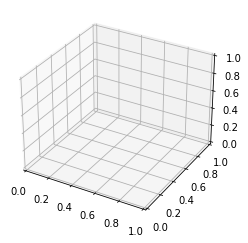

In [9]:
#Visualizing continuous head position: doesnt work

#mne.viz.plot_head_positions(head_pos, mode='traces')
mne.viz.plot_head_positions(head_pos, mode='field')



In [10]:
# Now again try to annotate movement: also error - It didnt calculate any positions!

mean_distance_limit = 0.0015  # in meters
annotation_movement, hpi_disp = annotate_movement(
    raw_cropped, head_pos, mean_distance_limit=mean_distance_limit)
raw_cropped.set_annotations(raw_cropped.annotations + annotation_movement)
raw_cropped.plot(n_channels=100, duration=20)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [11]:
head_pos

array([], shape=(0, 10), dtype=float64)

In [9]:
# https://pyprep.readthedocs.io/en/latest/generated/pyprep.NoisyChannels.html#pyprep.NoisyChannels

# This class implements all of the noisy channel detection methods used in the PREP pipeline, as described in:
# Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., Robbins, K. A. (2015). The PREP pipeline: 
# standardized preprocessing for large-scale EEG analysis. Frontiers in Neuroinformatics, 9, 16.

noisy = pp.NoisyChannels(raw) #first, add raw to class, then all the noisy channels finding performed on this new object.

# Doesnt work. Only EEG is supported. Tried to change channel type in just to try in:
# opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/pyprep/find_noisy_channels.py
# to self.raw_mne.pick_types(meg=True, verbose=True)
# no luck, it gives traceback on this line. 
# (If u explicitely call raw.pick_types(meg=True, verbose=True) - everything works fine - see cell above).

# Dont know where the issue is exactly, but in the end we ll need to rewrite this whole function 
# to work with MEG if we really need it.

from time import perf_counter

start_time = perf_counter()
#noisy.find_bad_by_ransac(channel_wise=True)
noisy.find_all_bads(ransac=True, channel_wise=False, max_chunk_size=None)
print("--- %s seconds ---" % (perf_counter() - start_time))

ValueError: No channels match the selection.